# GR 6901 Final Project
### Study of the impact of ENSO events on precipitation in the United States. 
### Name: Fangtong Mei 
### UNI: fm2867

### Datasets:
1.	Precipitation Data: Monthly precipitation data for the United States from 1982 to 2024, sourced from the NOAA database, with spatial resolutions of 0.25° and 0.6°.
2.	ENSO Index Data: ENSO index data provided by NOAA.

### Research Questions:
1.	Do ENSO events influence precipitation across the entire United States or only in specific regions?
2.	What is the time correlation between the intensity of ENSO events and precipitation amounts?
3.	Through seasonal visualization analysis of anomalous precipitation in the United States, which regions are most significantly affected by ENSO events?

### Loading Package

In [27]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import importlib.util
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from scipy.stats import pearsonr

# Step1: Data Extraction and Processing

### 1.Loading ENSO Index Data

In [28]:
path = '/home/jovyan/rces-assignments/dataset/anom.txt'
df = pd.read_csv(path, sep='\\s+')
df

YR  MON  NINO1+2  ANOM  NINO3  ANOM.1  NINO4  ANOM.2  NINO3.4  ANOM.3
0    1982    1    24.28 -0.24  25.84    0.17  28.01   -0.21    26.65    0.08
1    1982    2    25.38 -0.72  26.26   -0.11  27.99   -0.11    26.54   -0.20
2    1982    3    25.22 -1.38  26.92   -0.25  28.18   -0.05    27.09   -0.14
3    1982    4    24.57 -1.16  27.52   -0.05  28.61    0.10    27.83    0.02
4    1982    5    24.00 -0.62  27.70    0.49  29.19    0.40    28.37    0.49
..    ...  ...      ...   ...    ...     ...    ...     ...      ...     ...
509  2024    6    22.52 -0.65  26.51   -0.14  29.49    0.65    27.95    0.24
510  2024    7    21.42 -0.41  25.79   -0.08  29.39    0.60    27.51    0.21
511  2024    8    20.52 -0.34  24.97   -0.25  29.17    0.48    26.83   -0.07
512  2024    9    19.91 -0.68  24.85   -0.16  28.98    0.30    26.61   -0.15
513  2024   10    20.55 -0.32  25.03   -0.05  28.83    0.14    26.49   -0.28

[514 rows x 10 columns]

### 2. Select El Nino Event and La Nina Event
Define and filter El Niño and La Niña event sets based on the ANOM.3 index being greater than 0.5 or less than -0.5 for five consecutive months.

In [29]:
def filter_continuous_events(data, column, threshold, months, comparison):
    if comparison == 'gt':  
        condition = data[column] > threshold
    elif comparison == 'lt':  
        condition = data[column] < threshold
    else:
        raise ValueError("Invalid comparison. Use 'gt' for greater than or 'lt' for less than.")
    
    rolling_sum = condition.rolling(window=months, min_periods=months).sum()
    return data[rolling_sum == months]

el_nino = filter_continuous_events(df, 'ANOM.3', 0.5, 5, 'gt')  # 大于 0.5
el_nino['Condition'] = 'El Nino'
la_nina = filter_continuous_events(df, 'ANOM.3', -0.5, 5, 'lt')  # 小于 -0.5
la_nina['Condition'] = 'La Nina'

/tmp/ipykernel_1594/1235603698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  el_nino['Condition'] = 'El Nino'
/tmp/ipykernel_1594/1235603698.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  la_nina['Condition'] = 'La Nina'


### 3.Load Precipitation Data
select the Latitudes and Longitudes of the United States

In [30]:
file_path = '/home/jovyan/rces-assignments/dataset/precipitation/prec.nc'

prec = xr.open_dataset(file_path)
prec = prec.sel(
    lat=slice(49, 24),          
    lon=slice(235, 294)         
)

prec

<xarray.Dataset> Size: 396MB
Dimensions:  (time: 16758, lat: 50, lon: 118)
Coordinates:
  * lat      (lat) float32 200B 48.75 48.25 47.75 47.25 ... 25.25 24.75 24.25
  * lon      (lon) float32 472B 235.2 235.8 236.2 236.8 ... 292.8 293.2 293.8
  * time     (time) datetime64[ns] 134kB 1979-01-01 1979-01-02 ... 2024-11-17
Data variables:
    precip   (time, lat, lon) float32 395MB ...
Attributes:
    Conventions:    CF-1.0
    version:        V1.0
    history:        created 9/2016 by CAS NOAA/ESRL PSD
    title:          CPC GLOBAL PRCP V1.0
    dataset_title:  CPC GLOBAL PRCP V1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globalprec...

### 4.Resample the precipitation data to monthly intervals and calculate the average values

In [31]:
prec_m = prec.resample(time="1ME").mean()
prec_m['time'] = prec_m['time'].dt.strftime('%Y-%m')
prec_m['time'] = xr.DataArray(pd.to_datetime(prec_m['time']), dims="time")
prec_m

<xarray.Dataset> Size: 13MB
Dimensions:  (time: 551, lat: 50, lon: 118)
Coordinates:
  * lat      (lat) float32 200B 48.75 48.25 47.75 47.25 ... 25.25 24.75 24.25
  * lon      (lon) float32 472B 235.2 235.8 236.2 236.8 ... 292.8 293.2 293.8
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-11-01
Data variables:
    precip   (time, lat, lon) float32 13MB 3.288 2.091 1.406 ... 0.0 0.0 0.0
Attributes:
    Conventions:    CF-1.0
    version:        V1.0
    history:        created 9/2016 by CAS NOAA/ESRL PSD
    title:          CPC GLOBAL PRCP V1.0
    dataset_title:  CPC GLOBAL PRCP V1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globalprec...

# Step2: Data Analysis of ENSO Events and Anomalous Precipitation

### 1. Heatmap of ENSO Event Occurrences
According to the definitions of El Niño and La Niña events, use varying shades of color to represent the intensity levels. Red represents El Niño events, while blue represents La Niña events.

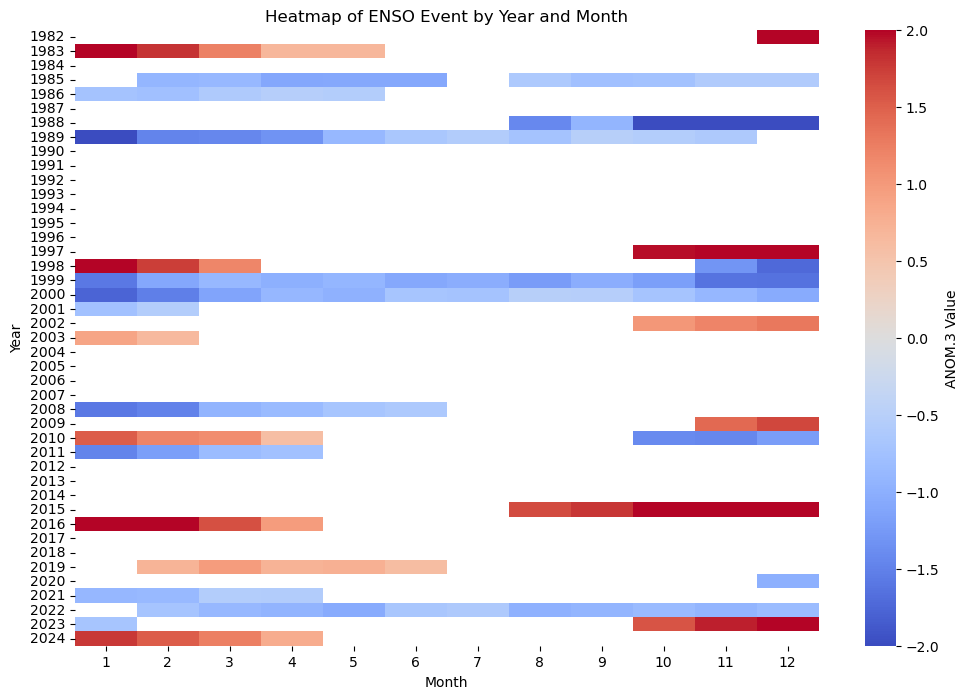

In [32]:
el_nino_new = pd.read_csv('dataset/el_nino_new.csv')
la_nina_new = pd.read_csv('dataset/la_nina_new.csv')
merged_data = pd.concat([el_nino_new, la_nina_new], ignore_index=True)
all_years = range(merged_data['YR'].min(), merged_data['YR'].max() + 1)
all_months = range(1, 13)
heatmap_data = merged_data.pivot(index='YR', columns='MON', values='ANOM.3')
heatmap_data = heatmap_data.reindex(index=all_years, columns=all_months)
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    cmap="coolwarm", 
    cbar_kws={'label': 'ANOM.3 Value'}, 
    annot=False, 
    fmt=".2f", 
    vmin=-2, 
    vmax=2, 
    center=0 
)
plt.title('Heatmap of ENSO Event by Year and Month')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

From the figure, it can be seen that the periods from December 1982 to May 1983, October 1997 to March 1998, November 2009 to April 2010, August 2015 to April 2016, and October 2023 to April 2024 are clear El Niño events, while the periods from August 1988 to November 1989 and November 1998 to February 2001 are clear La Niña events. These four time periods will be used in the subsequent visualization steps.

### 2.Analysis of Anomalous Precipitation Over Time
Calculate the long-term average and standard deviation of precipitation at each latitude and longitude point. Anomalous precipitation is defined as precipitation data at a point where the time series is greater than the mean plus one standard deviation or less than the mean minus one standard deviation.Plot a scatter plot of anomalous precipitation over time. Red points represent El Niño periods, and blue points represent La Niña periods. Additionally, perform a correlation analysis between the frequency of anomalous precipitation occurrences and time.

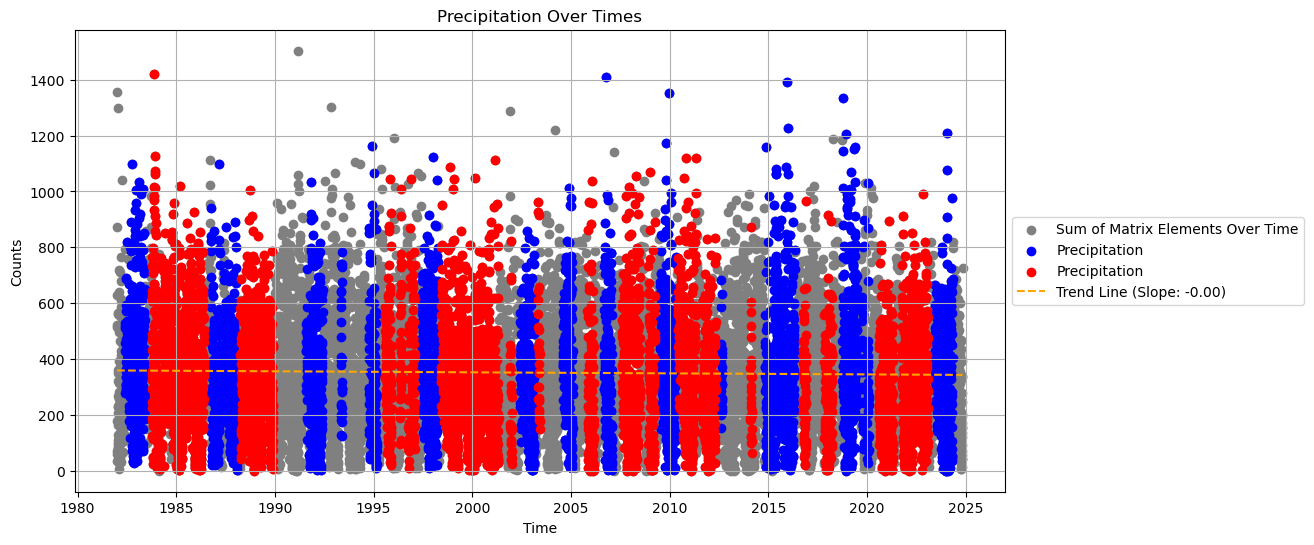

In [61]:
el_time = pd.read_csv('dataset/El_nino_timeseries.csv')
el_time['Date'] = pd.to_datetime(el_time['Date'])
la_time = pd.read_csv('dataset/La_nina_timeseries.csv')
la_time['Date'] = pd.to_datetime(la_time['Date'])
mean_precip = prec.precip.mean(dim='time')
std_precip = prec.precip.std(dim='time')
bool_matrix = ((prec.precip < (mean_precip - std_precip)) | 
               (prec.precip > (mean_precip + std_precip))).astype(int)
time_series_sum = bool_matrix.sum(dim=('lat', 'lon'))
time_series_sum
selected_times = el_time['Date'].values
sel_times = la_time['Date'].values
precip_data = time_series_sum.sel(time=selected_times)
p_data = time_series_sum.sel(time=sel_times)
plt.figure(figsize=(12, 6))
plt.scatter(prec.time, time_series_sum, color='gray', label="Sum of Matrix Elements Over Time")
plt.scatter(precip_data['time'], precip_data.values, color='blue', label='Precipitation')
plt.scatter(p_data['time'], p_data.values, color='Red', label='Precipitation')
time_numeric = np.arange(len(prec.time)) 
y_values = time_series_sum.values
slope, intercept = np.polyfit(time_numeric, y_values, 1)
trend_line = slope * time_numeric + intercept
plt.plot(prec.time, trend_line, color='orange', linestyle='--', label=f'Trend Line (Slope: {slope:.2f})')
plt.title('Precipitation Over Times')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

### 

### 3.Create box plots for El Niño events, La Niña events, and neutral events.

/tmp/ipykernel_1594/2135800850.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


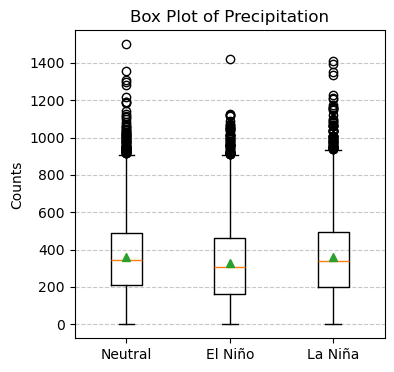

In [62]:
overall_data = neutral_dataarray.values    
el_nino_data = p_data.values         
la_nina_data = precip_data.values     
plt.figure(figsize=(4, 4))
plt.boxplot(
    [overall_data, el_nino_data, la_nina_data], 
    labels=['Neutral', 'El Niño', 'La Niña'], 
    showmeans=True
)
plt.title("Box Plot of Precipitation")
plt.ylabel("Counts")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 4.Calculate the number of outliers in the box plots

In [63]:
aligned_time_series, aligned_p_data, aligned_precip_data = xr.align(
    time_series_sum, p_data, precip_data, join="outer"
)
aligned_time_series = aligned_time_series.fillna(0)
aligned_p_data = aligned_p_data.fillna(0)
aligned_precip_data = aligned_precip_data.fillna(0)
neutral = aligned_time_series - aligned_p_data - aligned_precip_data
neutral_df = neutral.to_dataframe().reset_index()
neutral_nonzero = neutral_df[(neutral_df['precip'] != 0)]
neutral_nonzero['time'] = pd.to_datetime(neutral_nonzero['time'])
neutral_dataarray = xr.DataArray(
    neutral_nonzero['precip'].values, 
    coords={'time': neutral_nonzero['time'].values},  
    dims=['time'],  
    name='precip'  
)
overall_data = neutral_dataarray.values 
el_nino_data = p_data.values          
la_nina_data = precip_data.values      
def count_outliers(data):
    q1 = np.percentile(data, 25)  
    q3 = np.percentile(data, 75)
    iqr = q3 - q1  
    lower_bound = q1 - 1.5 * iqr  
    upper_bound = q3 + 1.5 * iqr 
    outliers = np.sum((data < lower_bound) | (data > upper_bound))
    return outliers
overall_outliers = count_outliers(overall_data)
el_nino_outliers = count_outliers(el_nino_data)
la_nina_outliers = count_outliers(la_nina_data)
print("Neutral outliers:", overall_outliers)
print("El Niño outliers:", el_nino_outliers)
print("La Niña outliers:", la_nina_outliers)
print("Neutral_data shape:", overall_data.shape)
print("el_nino_data shape:", el_nino_data.shape)
print("la_nina_data shape:", la_nina_data.shape)

Neutral outliers: 66
El Niño outliers: 55
La Niña outliers: 61
Neutral_data shape: (6994,)
el_nino_data shape: (4989,)
la_nina_data shape: (3653,)


/tmp/ipykernel_1594/194827963.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neutral_nonzero['time'] = pd.to_datetime(neutral_nonzero['time'])


### 5.Correlation analysis between precipitation and ANOM.3 data in the time series.
Since the ANOM.3 data used is only accurate to the monthly level, the months are expanded to days, and the daily ANOM.3 values are filled with the corresponding monthly values to align the time series for analysis.

/tmp/ipykernel_1594/3133132035.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation_map[i, j], _ = pearsonr(precip_series, enso_series)


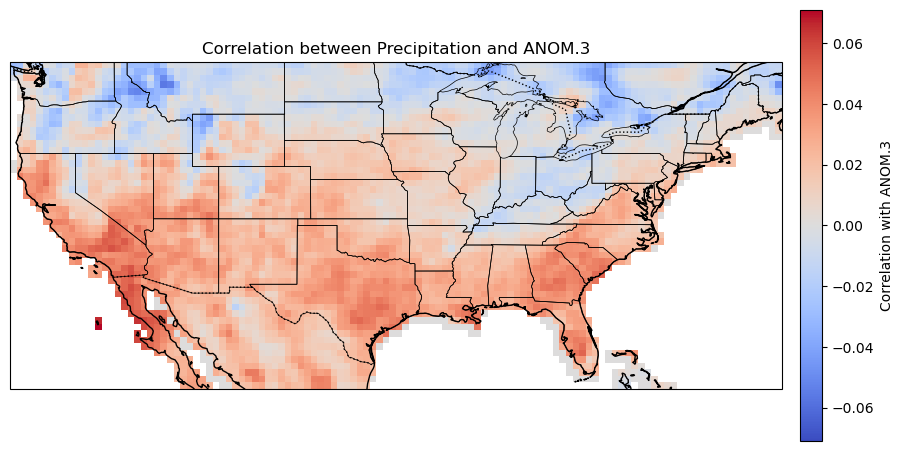

In [36]:
df_selected = df[['YR', 'MON', 'ANOM.3']]
expanded_data = []
for _, row in df_selected.iterrows():
    year = int(row['YR'])  
    month = int(row['MON']) 
    anom3 = row['ANOM.3']  
    start_date = pd.Timestamp(year=year, month=month, day=1)
    end_date = pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(0)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    for date in date_range:
        expanded_data.append({'Date': date, 'ANOM.3': anom3})
expanded_df = pd.DataFrame(expanded_data)
enso_daily_xr = xr.DataArray(
    expanded_df['ANOM.3'].values,  # ANOM.3 值
    coords={'time': pd.to_datetime(expanded_df['Date'])},  # 时间
    dims=['time'],
    name='enso_anom3'
)
prec = prec.sel(time=slice(enso_daily_xr.time.min(), enso_daily_xr.time.max()))
enso_daily_xr = enso_daily_xr.sel(time=prec['time'])
latitudes = prec['lat'].values
longitudes = prec['lon'].values
correlation_map = np.full((len(latitudes), len(longitudes)), np.nan)  
for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):
        precip_series = prec['precip'].sel(lat=lat, lon=lon).values 
        enso_series = enso_daily_xr.values 
        if not np.isnan(precip_series).all():
            correlation_map[i, j], _ = pearsonr(precip_series, enso_series)
correlation_dataarray = xr.DataArray(
    correlation_map,
    coords={'lat': latitudes, 'lon': longitudes},
    dims=['lat', 'lon'],
    name='correlation_with_anom3'
)
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
correlation_dataarray.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    cbar_kwargs={
        'label': 'Correlation with ANOM.3',
        'shrink': 0.7,               
        'aspect': 20,                
        'pad': 0.02
    }
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.title("Correlation between Precipitation and ANOM.3")
plt.show()

### 6.Time Series Correlation Analysis Between Winter ANOM.3 Index and Precipitation
Extract the winter months (December, January, and February) from the research data for correlation analysis.

/tmp/ipykernel_1594/910940084.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation_map[i, j], _ = pearsonr(precip_series, enso_series)


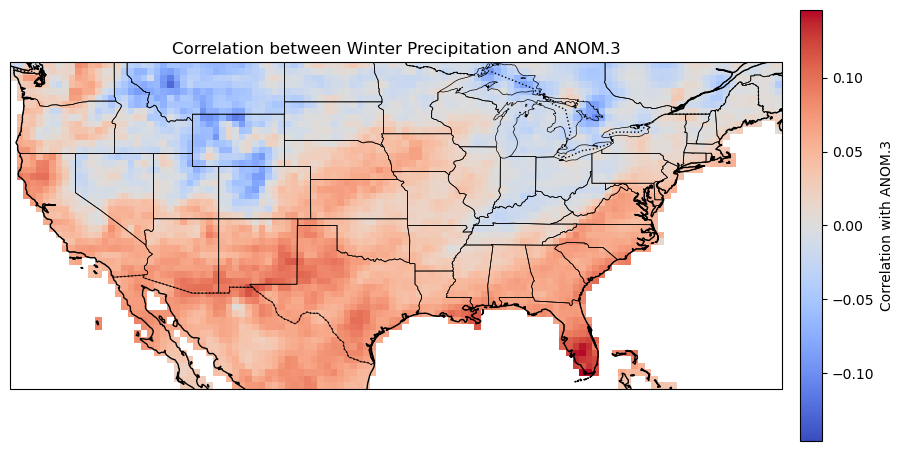

In [51]:
winter_df = expanded_df[expanded_df['Date'].dt.month.isin([12, 1, 2])]
winter_prec = prec.sel(time=prec['time'].dt.month.isin([12, 1, 2]))
enso_daily_xr = xr.DataArray(
    winter_df['ANOM.3'].values,  # ANOM.3 值
    coords={'time': pd.to_datetime(winter_df['Date'])},  # 时间
    dims=['time'],
    name='enso_anom3'
)
winter_prec = winter_prec.sel(time=slice(enso_daily_xr.time.min(), enso_daily_xr.time.max()))
enso_daily_xr = enso_daily_xr.sel(time=winter_prec['time'])
latitudes = winter_prec['lat'].values
longitudes = winter_prec['lon'].values
correlation_map = np.full((len(latitudes), len(longitudes)), np.nan)  

for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):
        precip_series = winter_prec['precip'].sel(lat=lat, lon=lon).values 
        enso_series = enso_daily_xr.values 

        if not np.isnan(precip_series).all():
            correlation_map[i, j], _ = pearsonr(precip_series, enso_series)
correlation_dataarray = xr.DataArray(
    correlation_map,
    coords={'lat': latitudes, 'lon': longitudes},
    dims=['lat', 'lon'],
    name='correlation_with_anom3'
)
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
correlation_dataarray.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    cbar_kwargs={
        'label': 'Correlation with ANOM.3',
        'shrink': 0.7,               
        'aspect': 20,                
        'pad': 0.02
    }
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.title("Correlation between Winter Precipitation and ANOM.3")
plt.show()

# Step3: Visualization Analysis of Anomalous Precipitation
In this section, I will conduct a visual analysis of the impact of El Niño and La Niña events on precipitation by season. The selected periods for El Niño and La Niña events were determined from the previous analysis of the heatmap.

### 1. Data processing
Calculate the long-term average precipitation by averaging the precipitation data over time, and obtain the anomalous precipitation data by subtracting the long-term average from the real-time precipitation.

In [38]:
prec_mean_time = prec.mean(dim='time')
prec_anomaly = prec - prec_mean_time
prec_anomaly = prec_anomaly.resample(time="1ME").mean()
prec_anomaly['time'] = prec_anomaly['time'].dt.strftime('%Y-%m')
prec_anomaly['time'] = xr.DataArray(pd.to_datetime(prec_anomaly['time']), dims="time")


### 2.El Niño
 <mark> 2.1 El Niño Winter Anomalous Precipitation Map </mark> 

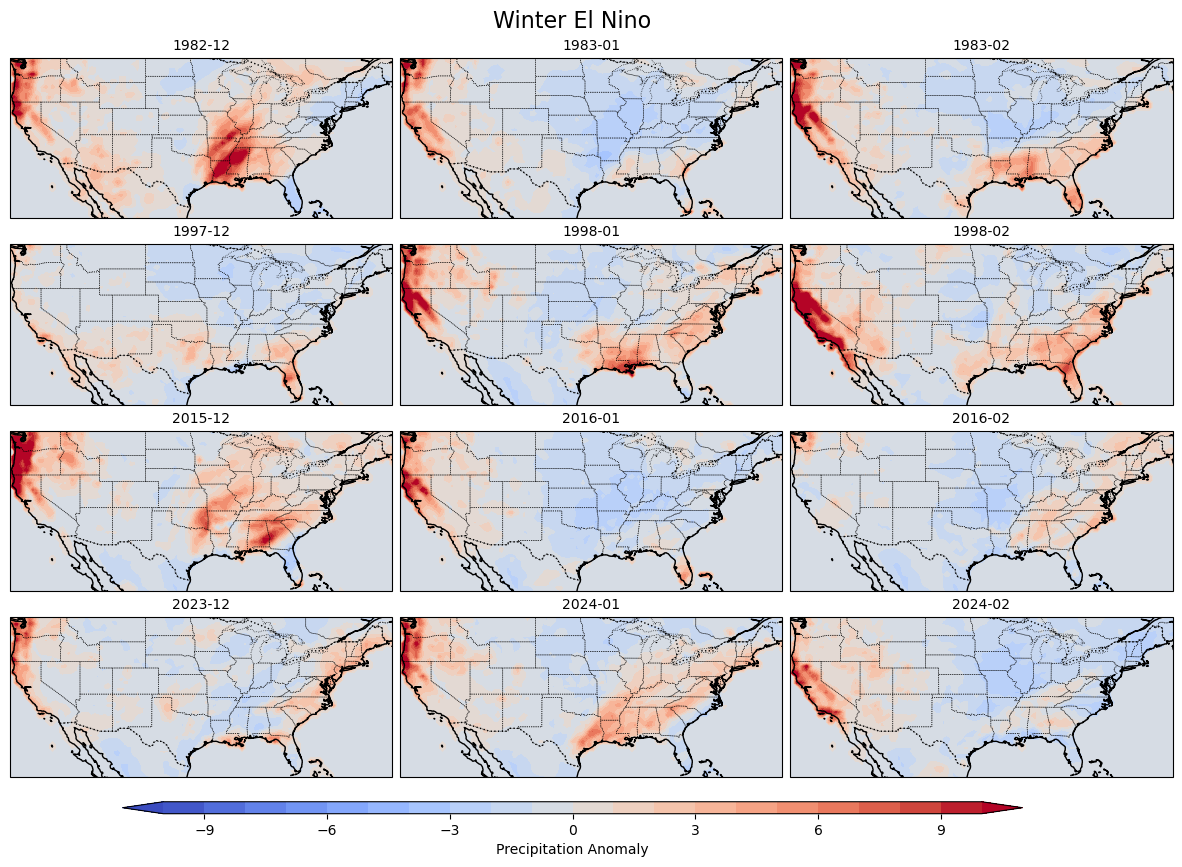

In [50]:
time_ranges = [
    pd.date_range('1982-12-01', '1983-02-01', freq='MS'),
    pd.date_range('1997-12-01', '1998-02-01', freq='MS'),
    pd.date_range('2015-12-01', '2016-02-01', freq='MS'),
    pd.date_range('2023-12-01', '2024-02-01', freq='MS'),
]

monthly_first_days = pd.concat([pd.Series(r) for r in time_ranges])

n_plots = len(monthly_first_days)
cols = 3
rows = 4

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

vmin = -10
vmax = 10

for i, date in enumerate(monthly_first_days):
    if date in prec_anomaly['time']:
        current_data = prec_anomaly.sel(time=date).precip
        ax = axes[i]
        im = ax.contourf(
            prec_anomaly['lon'],
            prec_anomaly['lat'],
            current_data,
            levels=np.linspace(vmin, vmax, 21),
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',
            extend='both'
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5, linestyle=':')
        ax.set_title(date.strftime('%Y-%m'), fontsize=10)
    else:
        axes[i].set_axis_off()

for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

fig.subplots_adjust(bottom=0.1, top=0.72, hspace= 0.01, wspace=0.02)

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.01])
cbar = fig.colorbar(
    im,
    cax=cbar_ax,
    orientation='horizontal'
) 
cbar.set_label('Precipitation Anomaly')

fig.suptitle('Winter El Nino', fontsize=16, y=0.75)

plt.show()

 <mark> 2.2 El Niño Spring Anomalous Precipitation Map </mark> 

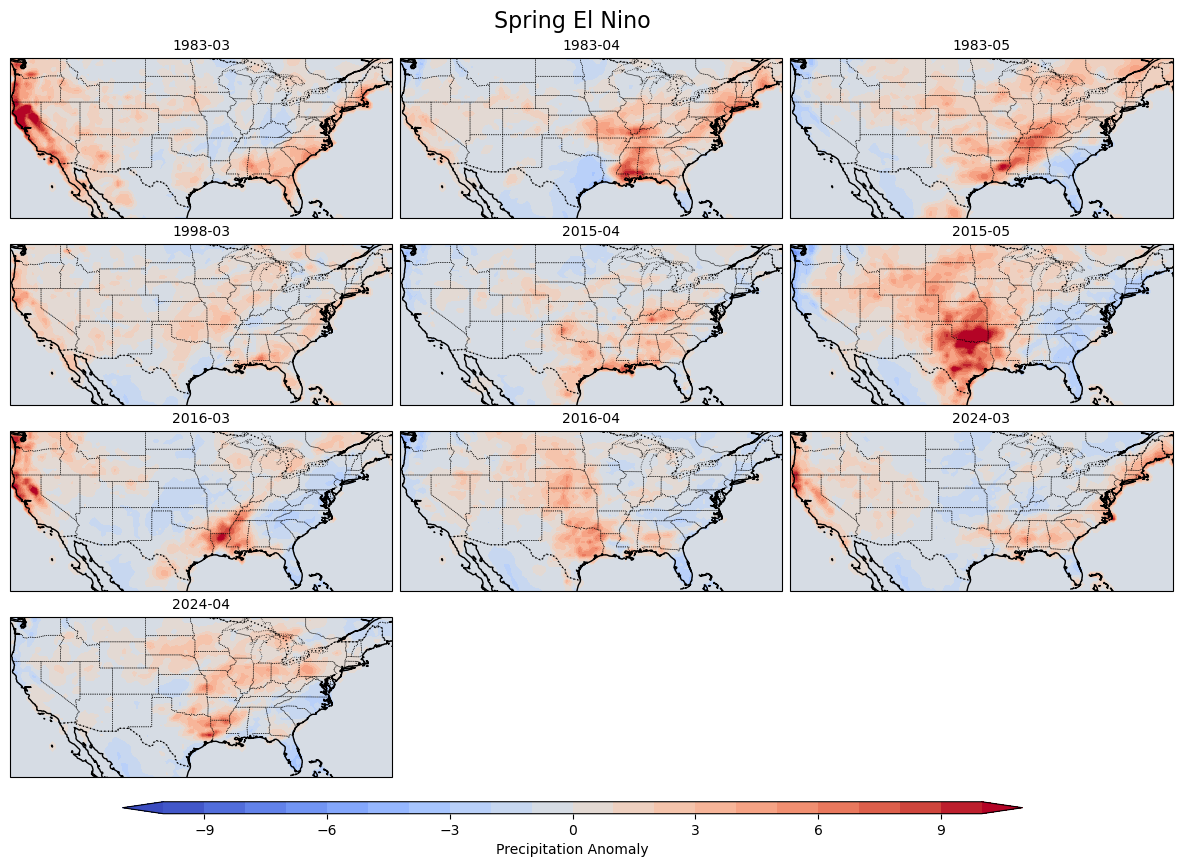

In [49]:
time_ranges = [
    pd.date_range('1983-03-01', '1983-05-01', freq='MS'),
    pd.date_range('1998-03-01', '1998-03-01', freq='MS'),
    pd.date_range('2015-04-01', '2015-05-01', freq='MS'),
    pd.date_range('2016-03-01', '2016-04-01', freq='MS'),
    pd.date_range('2024-03-01', '2024-04-01', freq='MS'),
]

monthly_first_days = pd.concat([pd.Series(r) for r in time_ranges])

n_plots = len(monthly_first_days)
cols = 3
rows = 4

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

vmin = -10
vmax = 10

for i, date in enumerate(monthly_first_days):
    if date in prec_anomaly['time']:
        current_data = prec_anomaly.sel(time=date).precip
        ax = axes[i]
        im = ax.contourf(
            prec_anomaly['lon'],
            prec_anomaly['lat'],
            current_data,
            levels=np.linspace(vmin, vmax, 21),
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',
            extend='both'
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5, linestyle=':')
        ax.set_title(date.strftime('%Y-%m'), fontsize=10)
    else:
        axes[i].set_axis_off()

for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

fig.subplots_adjust(bottom=0.1, top=0.72, hspace= 0.01, wspace=0.02)

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.01])
cbar = fig.colorbar(
    im,
    cax=cbar_ax,
    orientation='horizontal'
) 
cbar.set_label('Precipitation Anomaly')

fig.suptitle('Spring El Nino', fontsize=16, y=0.75)

plt.show()

 <mark> 2.3 El Niño Summer Anomalous Precipitation Map </mark> 

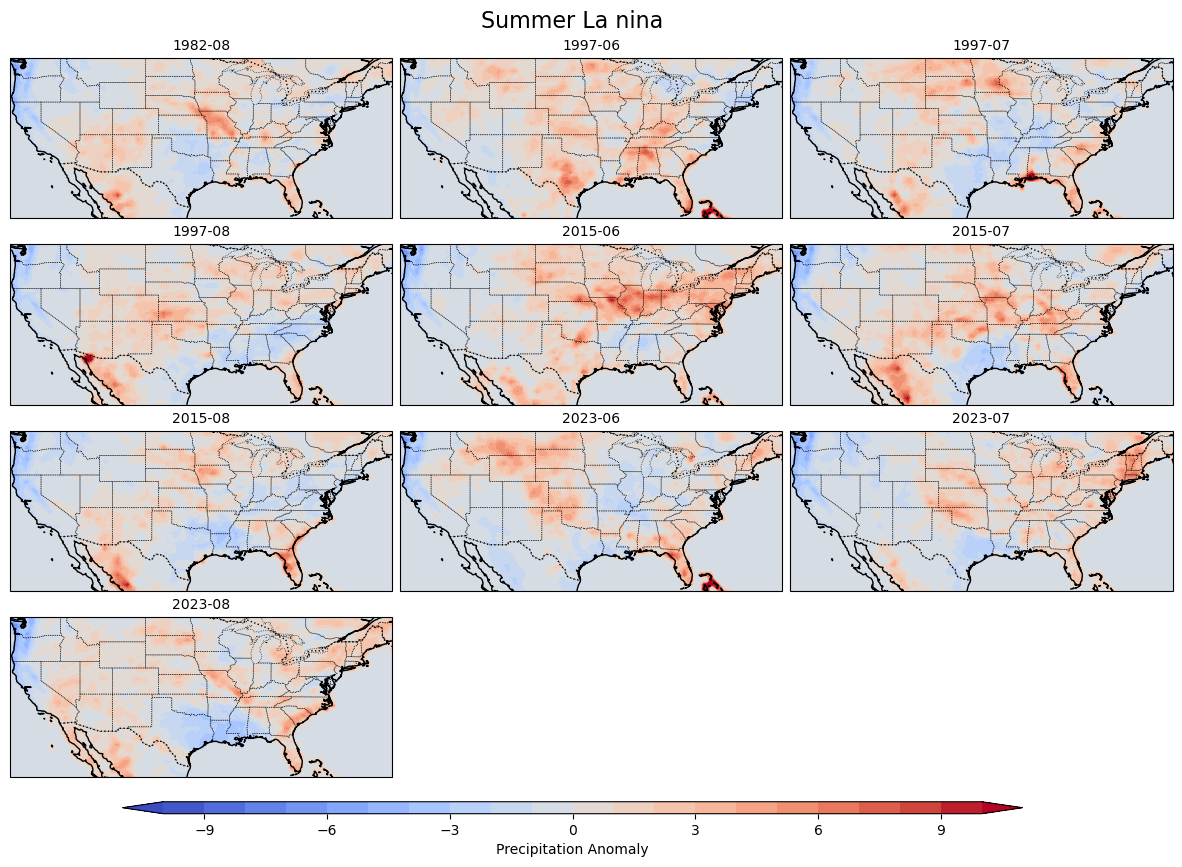

In [58]:
time_ranges = [
    pd.date_range('1982-08-01', '1982-08-01', freq='MS'),
    pd.date_range('1997-06-01', '1997-08-01', freq='MS'),
    pd.date_range('2015-06-01', '2015-08-01', freq='MS'),
    pd.date_range('2023-06-01', '2023-08-01', freq='MS'),
]

monthly_first_days = pd.concat([pd.Series(r) for r in time_ranges])

n_plots = len(monthly_first_days)
cols = 3
rows = 4

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

vmin = -10
vmax = 10

for i, date in enumerate(monthly_first_days):
    if date in prec_anomaly['time']:
        current_data = prec_anomaly.sel(time=date).precip
        ax = axes[i]
        im = ax.contourf(
            prec_anomaly['lon'],
            prec_anomaly['lat'],
            current_data,
            levels=np.linspace(vmin, vmax, 21),
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',
            extend='both'
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5, linestyle=':')
        ax.set_title(date.strftime('%Y-%m'), fontsize=10)
    else:
        axes[i].set_axis_off()

for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

fig.subplots_adjust(bottom=0.1, top=0.72, hspace= 0.01, wspace=0.02)

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.01])
cbar = fig.colorbar(
    im,
    cax=cbar_ax,
    orientation='horizontal'
) 
cbar.set_label('Precipitation Anomaly')

fig.suptitle('Summer La nina', fontsize=16, y=0.75)

plt.show()

 <mark> 2.4 El Niño Autumn Anomalous Precipitation Map </mark> 

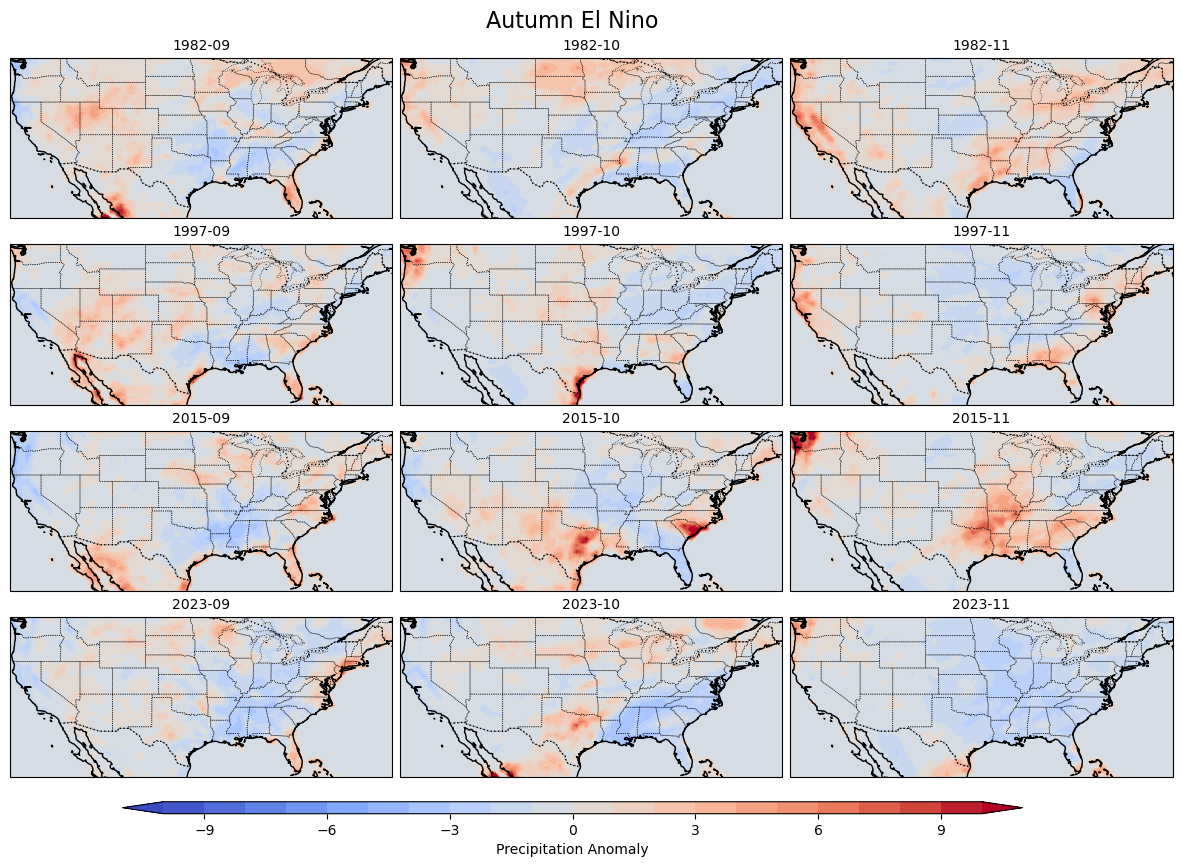

In [54]:
time_ranges = [
    pd.date_range('1982-09-01', '1982-11-01', freq='MS'),
    pd.date_range('1997-09-01', '1997-11-01', freq='MS'),
    pd.date_range('2015-09-01', '2015-11-01', freq='MS'),
    pd.date_range('2023-09-01', '2023-11-01', freq='MS'),
]

monthly_first_days = pd.concat([pd.Series(r) for r in time_ranges])

n_plots = len(monthly_first_days)
cols = 3
rows = 4

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

vmin = -10
vmax = 10

for i, date in enumerate(monthly_first_days):
    if date in prec_anomaly['time']:
        current_data = prec_anomaly.sel(time=date).precip
        ax = axes[i]
        im = ax.contourf(
            prec_anomaly['lon'],
            prec_anomaly['lat'],
            current_data,
            levels=np.linspace(vmin, vmax, 21),
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',
            extend='both'
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5, linestyle=':')
        ax.set_title(date.strftime('%Y-%m'), fontsize=10)
    else:
        axes[i].set_axis_off()

for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

fig.subplots_adjust(bottom=0.1, top=0.72, hspace= 0.01, wspace=0.02)

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.01])
cbar = fig.colorbar(
    im,
    cax=cbar_ax,
    orientation='horizontal'
) 
cbar.set_label('Precipitation Anomaly')

fig.suptitle('Autumn El Nino', fontsize=16, y=0.75)

plt.show()

### 3. La Niña
 <mark> 3.1 La Niña Winter Anomalous Precipitation Map </mark> 

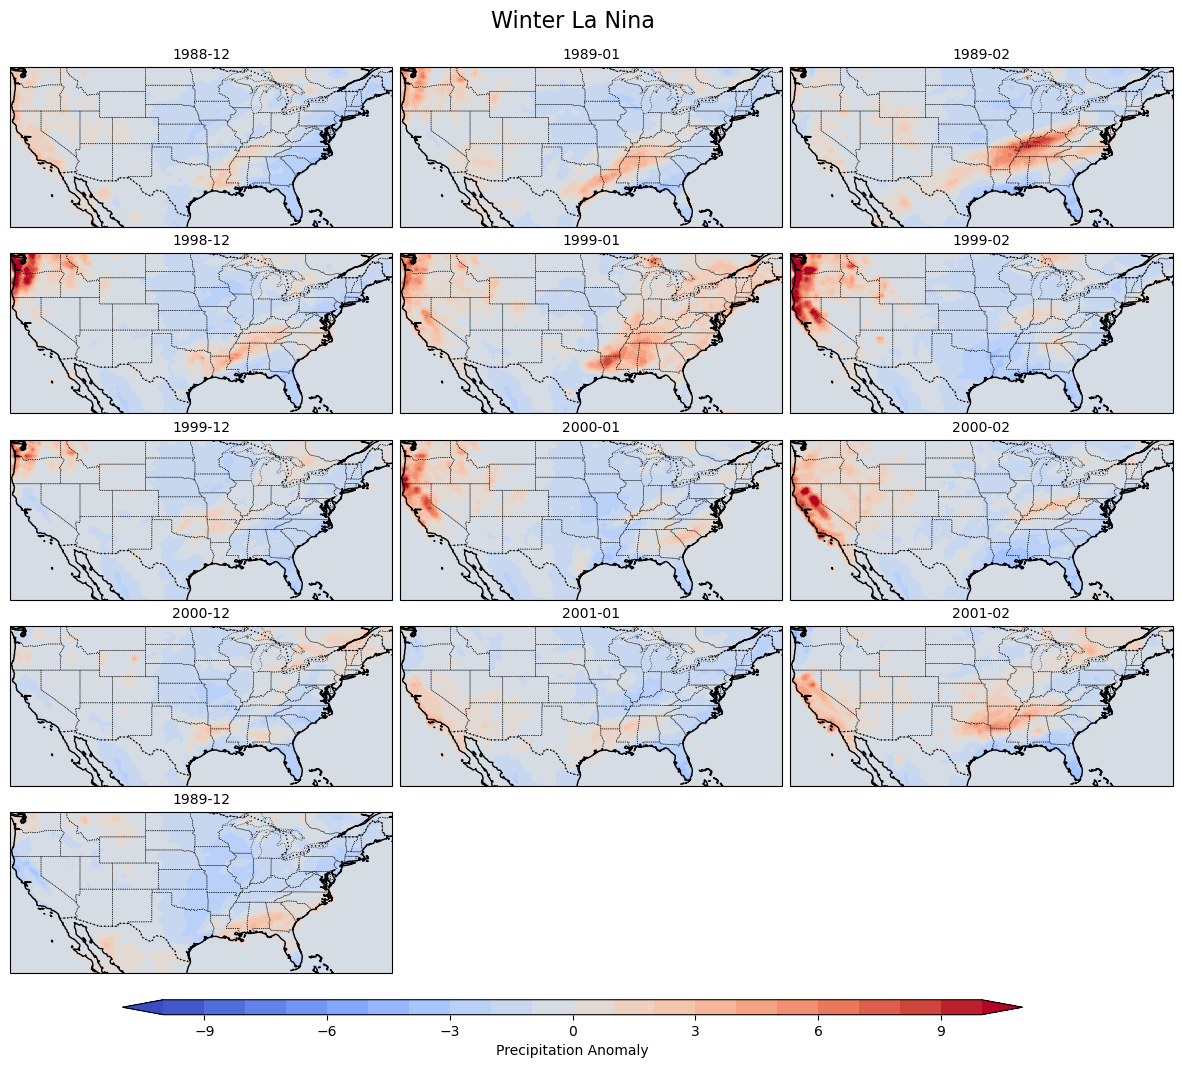

In [55]:
time_ranges = [
    pd.date_range('1988-12-01', '1989-02-01', freq='MS'),
    pd.date_range('1998-12-01', '1999-02-01', freq='MS'),
    pd.date_range('1999-12-01', '2000-02-01', freq='MS'),
    pd.date_range('2000-12-01', '2001-02-01', freq='MS'),
    pd.date_range('1989-12-01', '1989-12-01', freq='MS'),
]

monthly_first_days = pd.concat([pd.Series(r) for r in time_ranges])

n_plots = len(monthly_first_days)
cols = 3
rows = 5

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

vmin = -10
vmax = 10

for i, date in enumerate(monthly_first_days):
    if date in prec_anomaly['time']:
        current_data = prec_anomaly.sel(time=date).precip
        ax = axes[i]
        im = ax.contourf(
            prec_anomaly['lon'],
            prec_anomaly['lat'],
            current_data,
            levels=np.linspace(vmin, vmax, 21),
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',
            extend='both'
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5, linestyle=':')
        ax.set_title(date.strftime('%Y-%m'), fontsize=10)
    else:
        axes[i].set_axis_off()

for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

fig.subplots_adjust(bottom=0.1, top=0.72, hspace= 0.01, wspace=0.02)

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.01])
cbar = fig.colorbar(
    im,
    cax=cbar_ax,
    orientation='horizontal'
) 
cbar.set_label('Precipitation Anomaly')

fig.suptitle('Winter La Nina', fontsize=16, y=0.75)

plt.show()

 <mark> 3.2 La Niña Spring Anomalous Precipitation Map </mark> 

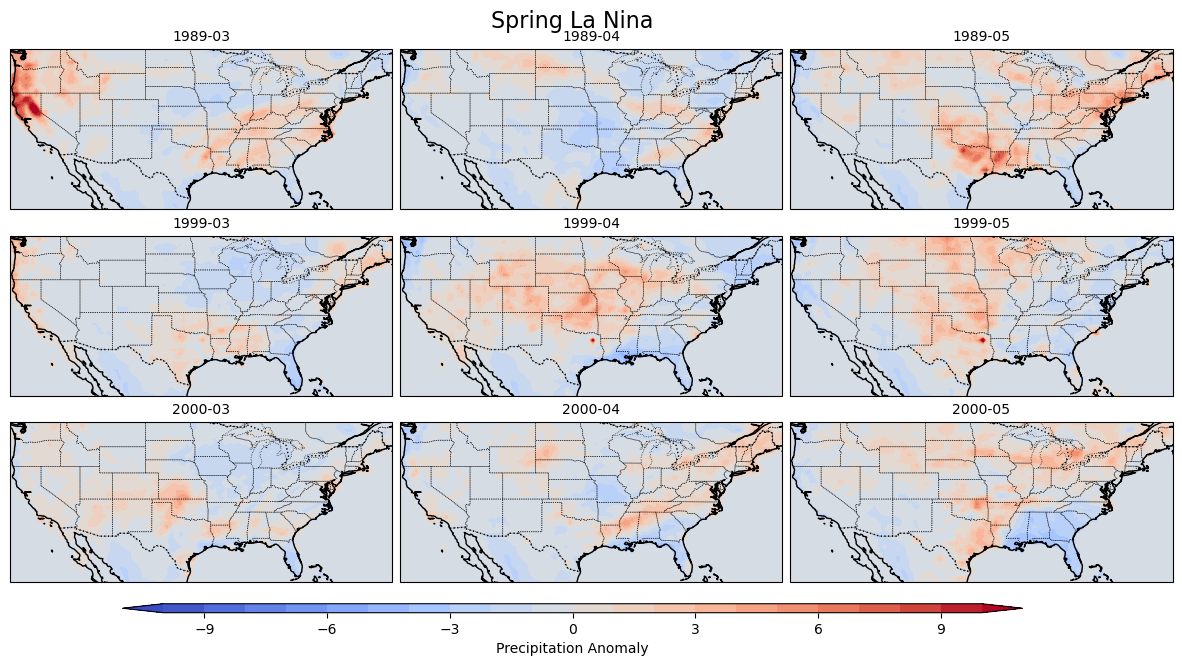

In [56]:
time_ranges = [
    pd.date_range('1989-03-01', '1989-05-01', freq='MS'),
    pd.date_range('1999-03-01', '1999-05-01', freq='MS'),
    pd.date_range('2000-03-01', '2000-05-01', freq='MS'),
]

monthly_first_days = pd.concat([pd.Series(r) for r in time_ranges])

n_plots = len(monthly_first_days)
cols = 3
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

vmin = -10
vmax = 10

for i, date in enumerate(monthly_first_days):
    if date in prec_anomaly['time']:
        current_data = prec_anomaly.sel(time=date).precip
        ax = axes[i]
        im = ax.contourf(
            prec_anomaly['lon'],
            prec_anomaly['lat'],
            current_data,
            levels=np.linspace(vmin, vmax, 21),
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',
            extend='both'
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5, linestyle=':')
        ax.set_title(date.strftime('%Y-%m'), fontsize=10)
    else:
        axes[i].set_axis_off()

for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

fig.subplots_adjust(bottom=0.1, top=0.72, hspace= 0.01, wspace=0.02)

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.01])
cbar = fig.colorbar(
    im,
    cax=cbar_ax,
    orientation='horizontal'
) 
cbar.set_label('Precipitation Anomaly')

fig.suptitle('Spring La Nina', fontsize=16, y=0.75)

plt.show()

3.3 La Niña Summer Anomalous Precipitation Map

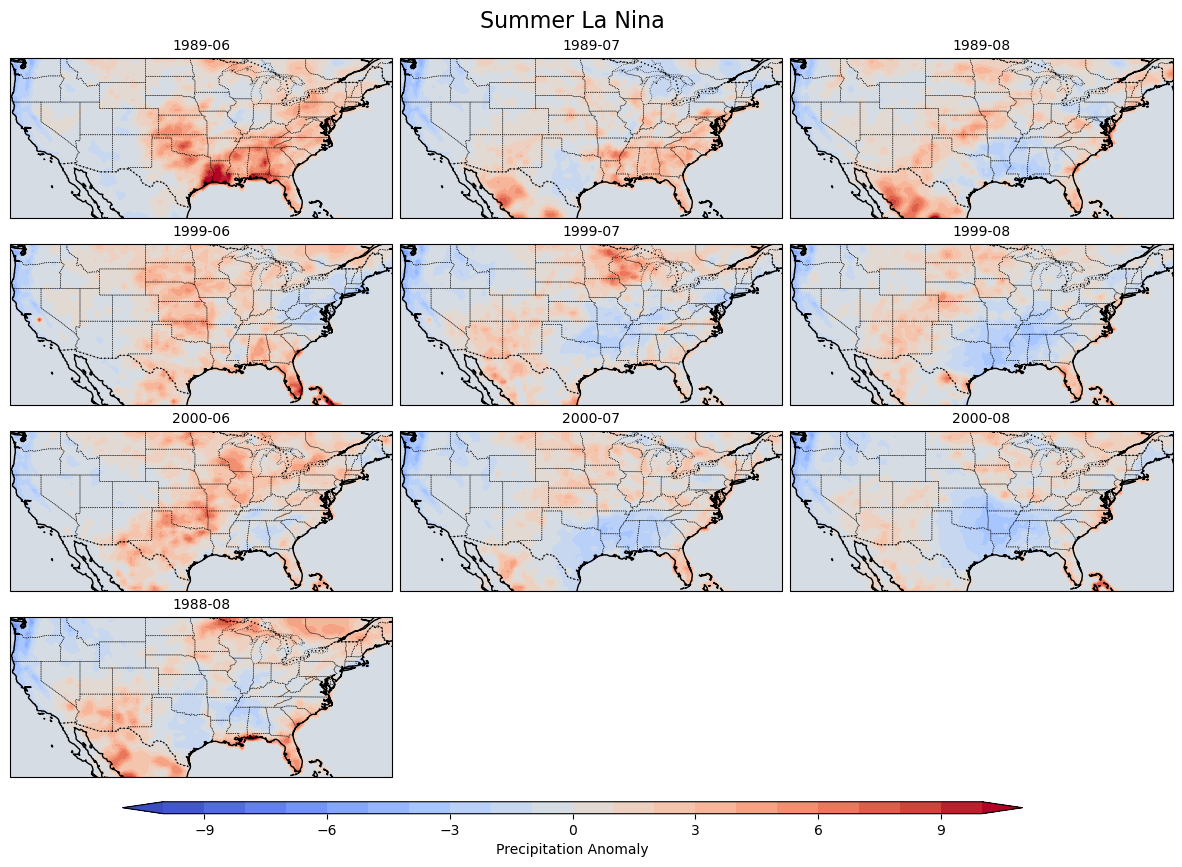

In [59]:
time_ranges = [
    pd.date_range('1989-06-01', '1989-08-01', freq='MS'),
    pd.date_range('1999-06-01', '1999-08-01', freq='MS'),
    pd.date_range('2000-06-01', '2000-08-01', freq='MS'),
    pd.date_range('1988-08-01', '1988-08-01', freq='MS'),
]

monthly_first_days = pd.concat([pd.Series(r) for r in time_ranges])

n_plots = len(monthly_first_days)
cols = 3
rows = 4

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

vmin = -10
vmax = 10

for i, date in enumerate(monthly_first_days):
    if date in prec_anomaly['time']:
        current_data = prec_anomaly.sel(time=date).precip
        ax = axes[i]
        im = ax.contourf(
            prec_anomaly['lon'],
            prec_anomaly['lat'],
            current_data,
            levels=np.linspace(vmin, vmax, 21),
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',
            extend='both'
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5, linestyle=':')
        ax.set_title(date.strftime('%Y-%m'), fontsize=10)
    else:
        axes[i].set_axis_off()

for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

fig.subplots_adjust(bottom=0.1, top=0.72, hspace= 0.01, wspace=0.02)

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.01])
cbar = fig.colorbar(
    im,
    cax=cbar_ax,
    orientation='horizontal'
) 
cbar.set_label('Precipitation Anomaly')

fig.suptitle('Summer La Nina', fontsize=16, y=0.75)

plt.show()

 <mark> 3.4 La Niña Autumn Anomalous Precipitation Map </mark> 

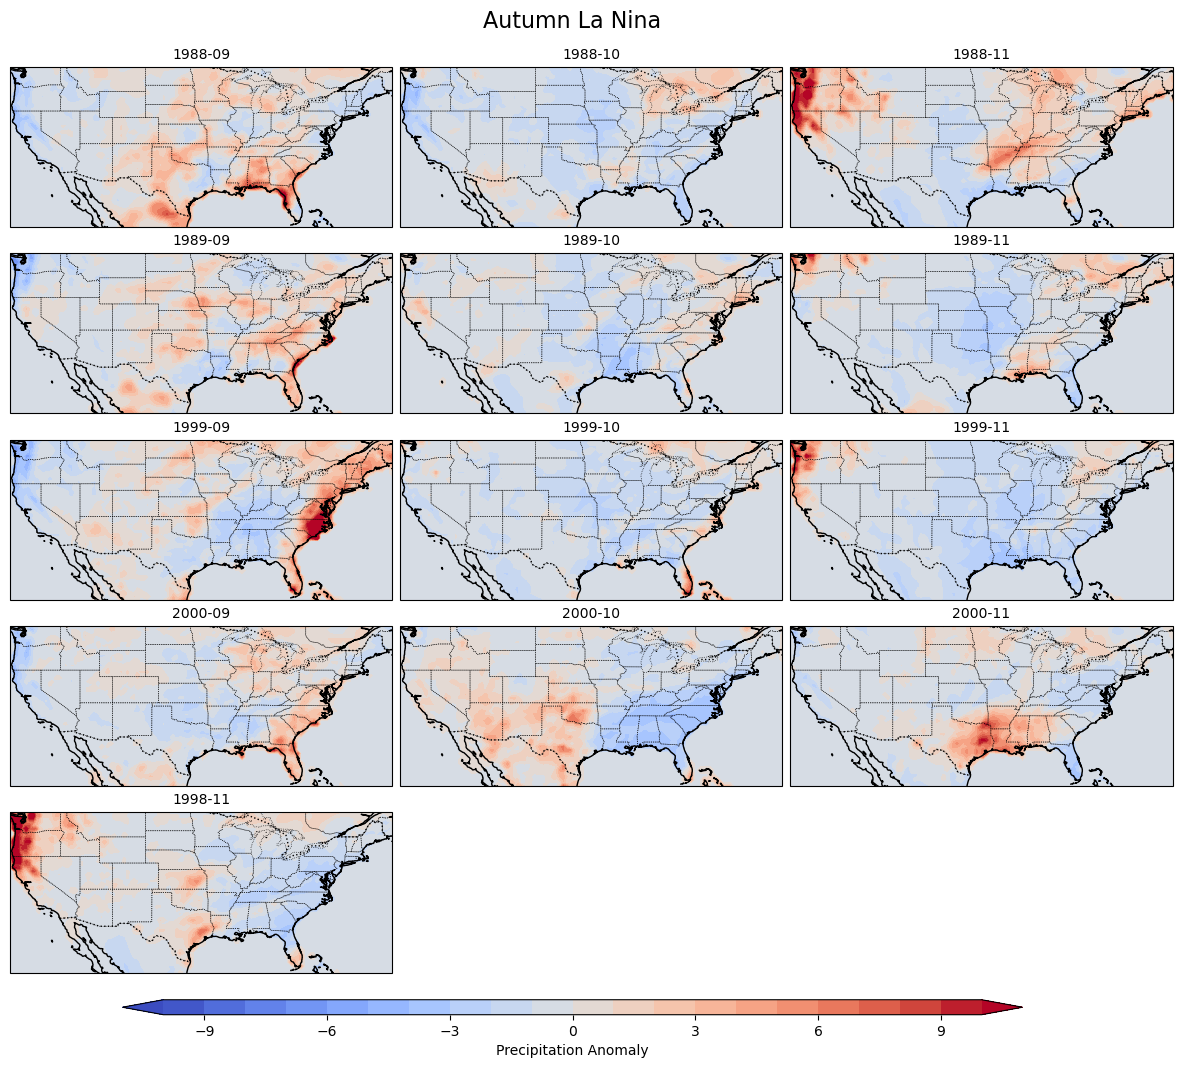

In [57]:
time_ranges = [
    pd.date_range('1988-09-01', '1988-11-01', freq='MS'),
    pd.date_range('1989-09-01', '1989-11-01', freq='MS'),
    pd.date_range('1999-09-01', '1999-11-01', freq='MS'),
    pd.date_range('2000-09-01', '2000-11-01', freq='MS'),
    pd.date_range('1998-11-01', '1998-11-01', freq='MS'),
]

monthly_first_days = pd.concat([pd.Series(r) for r in time_ranges])

n_plots = len(monthly_first_days)
cols = 3
rows = 5

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

vmin = -10
vmax = 10

for i, date in enumerate(monthly_first_days):
    if date in prec_anomaly['time']:
        current_data = prec_anomaly.sel(time=date).precip
        ax = axes[i]
        im = ax.contourf(
            prec_anomaly['lon'],
            prec_anomaly['lat'],
            current_data,
            levels=np.linspace(vmin, vmax, 21),
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',
            extend='both'
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5, linestyle=':')
        ax.set_title(date.strftime('%Y-%m'), fontsize=10)
    else:
        axes[i].set_axis_off()

for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

fig.subplots_adjust(bottom=0.1, top=0.72, hspace= 0.01, wspace=0.02)

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.01])
cbar = fig.colorbar(
    im,
    cax=cbar_ax,
    orientation='horizontal'
) 
cbar.set_label('Precipitation Anomaly')

fig.suptitle('Autumn La Nina', fontsize=16, y=0.75)

plt.show()

# Result and Analysis
1. Through the analysis of the scatter plot, the frequency of anomalous precipitation across the United States has remained stable over the past 40 years.  
2. Through the analysis of the scatter plot, it can be seen that when the y-values are above 800, most points are colored, indicating that ENSO events have a widespread impact on the United States.Through the box plots and analysis of outliers, it was found that during the neutral periods of 8,107 days, there were only 74 instances of large-scale anomalous precipitation events. However, during ENSO events spanning a total of 8,642 days, there were 115 instances of large-scale anomalous precipitation events.  
3. During the correlation analysis, I found that the correlation between the ANOM.3 index and precipitation is not high. After reviewing the literature(source is showed in Picture file named Correlation), I learned that, taking El Niño events as an example: in strong El Niño events, the occurrence of increased precipitation events is highly probable, whereas in neutral and weak El Niño events, the probability of increased precipitation events is only one-third. In about one-third of the years, precipitation actually decreased. So this explains why the correlation coefficient is not high. Additionally, after reviewing more literature, I found that the occurrence of ENSO events is more significant and consistent during winter. Therefore, I conducted a correlation analysis for the winter season, and the results indicate that the correlation coefficient did indeed increase.The conclusion is occurrence of ENSO events is correlated with anomalous precipitation, but their impact on precipitation cannot be predicted solely based on the strength of the ENSO events.  
4. In the visualization analysis, I only examined whether the impact of ENSO events on winter precipitation aligns with the conclusions from the literature. The results indicate that they do, and the related findings can be seen in the images named “El Niño” and “La Niña.” During El Niño winter periods, precipitation in California and Florida significantly increases, overall precipitation in the southern United States increases, and precipitation in the northern regions decreases. Conversely, during La Niña winter periods, the southern United States becomes generally drier, while precipitation increases in the central and northeastern regions.As for why other seasons were not studied, the images also show anomalous precipitation for those seasons. However, I believe this is because I calculated the long-term average precipitation for each point without taking seasonal averages. This approach means that seasonal precipitation variations also lead to the occurrence of anomalous values in the results, which I consider normal. Additionally, significant impact events do not occur in a regular pattern, making it difficult to discern any underlying trends.